# MODFLOW-MT3DMS with Flopy

This notebook is based on Harry Lees [lecture](https://www2.hawaii.edu/~jonghyun/classes/S18/CEE696/files/11_flopy_mt3dms_transport_modeling.pdf) about mt3dms with flopy.

The original notebook can be found [here].(https://www2.hawaii.edu/~jonghyun/classes/S18/CEE696/files/my_first_flopy_mt3dms_example.py) 

The overview of all lectures are [here](https://www2.hawaii.edu/~jonghyun/classes/S18/CEE696/schedule.html).

In [1]:
import numpy as np
import flopy

### Assign name and create modflow model object

In [2]:
modelname = 'mf-mt'
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')

### Model domain and grid definition
Discretization Object

In [3]:
Lx = 1000.
Ly = 1000.
ztop = 0.
zbot = -50.
nlay = 1
nrow = 50
ncol = 50
delr = Lx/ncol
delc = Ly/nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

dis = flopy.modflow.ModflowDis(
    mf, 
    nlay, 
    nrow, 
    ncol, 
    delr=delr, 
    delc=delc,
    top=ztop, 
    botm=botm[1:]
)

### Variables for the BAS package

In [4]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 10.
strt[:, :, -1] = 0.
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

### LPF-Package

In [5]:
lpf = flopy.modflow.ModflowLpf(mf, hk=10., vka=10., ipakcb=53)

### OC-Package

In [6]:
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

### WEL-Package

In [7]:
pumping_rate = 1000.
wcol = round(nrow/10) # x index for the well
wrow = round(ncol/2)  # y index for the well
wel_sp = [[0, wrow, wcol, pumping_rate]] # lay, row, col index, pumping rate
stress_period_data = {0: wel_sp} # define well stress period {period, well info dictionary}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)

### PCG-Package

In [8]:
pcg = flopy.modflow.ModflowPcg(mf)

### Linkage to mt3dms LMT-Package

In [9]:
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')

### Write MODFLOW model input files

In [10]:
mf.write_input()

### Run the modflow model

In [11]:
success, buff = mf.run_model()

FloPy is using the following executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf-mt.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/26 12:05:42

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/26 12:05:42
 Elapsed run time:  0.015 Seconds

  Normal termination of simulation


### Create mt3dms model object

In [12]:
mt = flopy.mt3d.Mt3dms(
    modflowmodel=mf,
    modelname=modelname, 
    exe_name='mt3dms',
    ftlfilename='mt3d_link.ftl',
    verbose=True
)

### Basic transport package

In [13]:
btn = flopy.mt3d.Mt3dBtn(
    mt, 
    prsity = 0.3, 
    icbund = 1, 
    sconc = 0.0, 
    ncomp = 1, 
    perlen = 1000, 
    nper = 1, 
    nstp = 50, 
    tsmult = 1.0, 
    nprs = -1, 
    nprobs = 10, 
    cinact = -1, 
    chkmas = True
)

adding Package:  BTN


### Advaction package

In [14]:
adv = flopy.mt3d.Mt3dAdv(mt, mixelm = -1, percel = 0.75)

adding Package:  ADV


### Dispersion package

In [15]:
dsp = flopy.mt3d.Mt3dDsp(mt, al = 10.0, trpt = 0.1, trpv = 0.1, dmcoef = 1e-09)

adding Package:  DSP


### Source/Sink Package

In [16]:
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict()
ssm_data[0] = [(0, wrow, wcol, 10.0, itype['WEL'])]
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)

adding Package:  SSM


### Matrix solver package

In [17]:
gcg = flopy.mt3d.Mt3dGcg(mt, cclose=1e-6)

adding Package:  GCG


### Write mt3dms input

In [18]:
mt.write_input()


Writing packages:
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  SSM
   Package:  GCG
 


### Run mt3dms

In [19]:
mt.run_model(normal_msg='Program completed', silent=True)

(True, [])

## Post processing and plotting
### Create flopy plot object, plot grid and contour

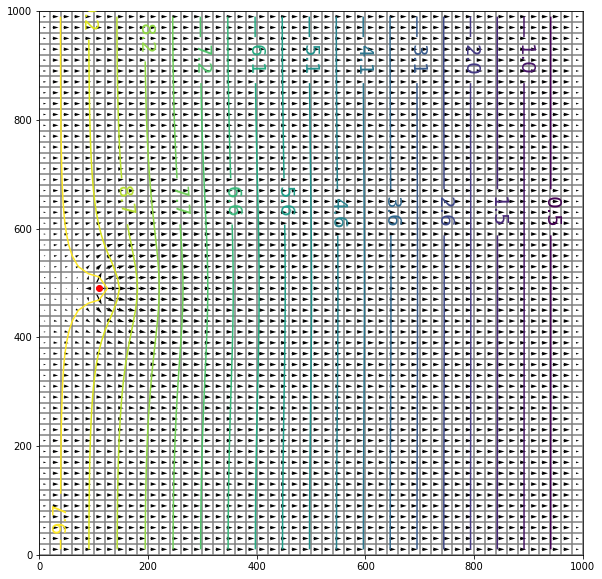

In [20]:
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

wpt = ((wcol+0.5)*delr, Lx - ((wrow + 0.5)*delc)) # origin at low upper..
hds = bf.HeadFile(modelname+'.hds')
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])

cbb = bf.CellBudgetFile(modelname+'.cbc') # read budget file
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

modelmap = flopy.plot.ModelMap(model=mf, layer=0)
lc = modelmap.plot_grid() # grid
cs = modelmap.contour_array(head, levels=np.linspace(head.min(), head.max(), 21)) # head contour
plt.clabel(cs, fontsize=20, fmt='%1.1f', zorder=1) # contour label
quiver = modelmap.plot_discharge(frf, fff, head=head) # quiver
plt.plot(wpt[0],wpt[1],'ro') # well location
plt.show()

## Plot concentraction

In [21]:
ucnobj = bf.UcnFile('MT3D001.UCN')
#print(ucnobj.list_records()) # get values

times = ucnobj.get_times() # simulation time
times1 = times[round(len(times)/4.)] # 1/4 simulation time
times2 = times[round(len(times)/2.)] # 1/2 simulation time
times3 = times[-1] # the last simulation time

conc1 = ucnobj.get_data(totim=times1)
conc2 = ucnobj.get_data(totim=times2)
conc3 = ucnobj.get_data(totim=times3)

### Concentration 100 days

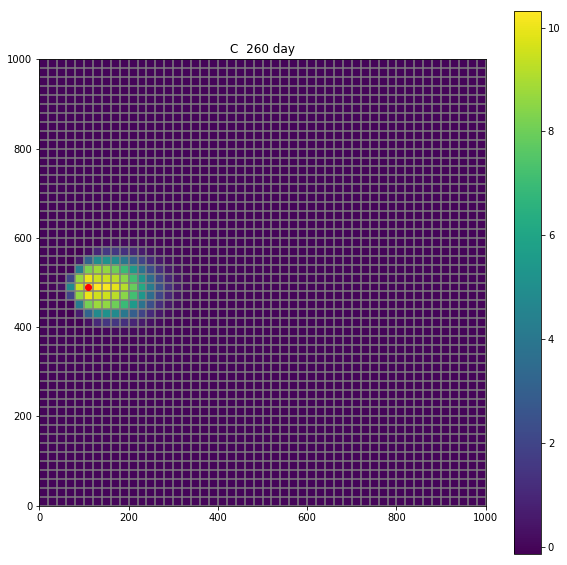

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf, layer=0)
lc = modelmap.plot_grid() # grid
cs = modelmap.plot_array(conc1) # head contour
plt.colorbar(cs) # colrobar
plt.plot(wpt[0],wpt[1],'ro')
plt.title('C  %g day' % times1)
plt.show()

In [23]:
### Concentration 500 days

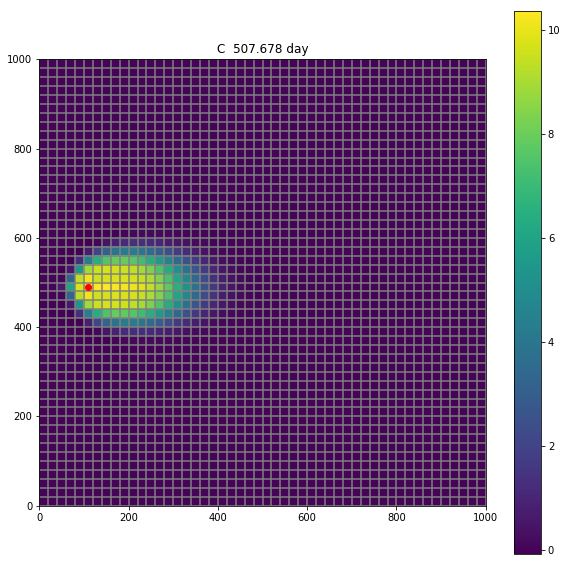

In [24]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf, layer=0)
lc = modelmap.plot_grid() # grid
cs = modelmap.plot_array(conc2) # head contour
plt.colorbar(cs) # colrobar
plt.plot(wpt[0],wpt[1],'ro')
plt.title('C  %g day' % times2)
plt.show()

### Concentration 1000 days

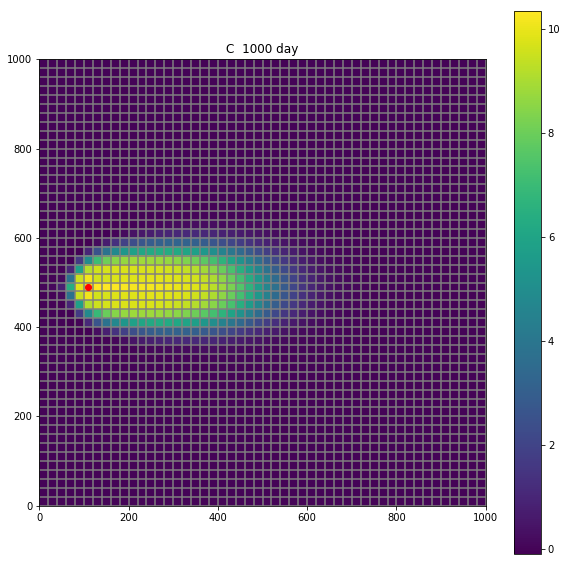

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf, layer=0)
lc = modelmap.plot_grid() # grid
cs = modelmap.plot_array(conc3) # head contour
plt.colorbar(cs) # colrobar
plt.plot(wpt[0],wpt[1],'ro')
plt.title('C  %g day' % times3)
plt.show()